# Introduction

This work presents a constrained combinatorial optimization approach to the **Sports League Assignment Problem** using **Genetic Algorithms (GAs)**. The objective is to allocate a fixed pool of professional players into a set of 5 structurally valid teams in such a way that the **standard deviation of the teams\\' average skill ratings** is minimized—promoting competitive balance across the league.

Each player is defined by three attributes: **position** (one of `GK`, `DEF`, `MID`, `FWD`), **skill rating** (a numerical measure of ability), and **cost** (in million euros). A valid solution must satisfy the following **hard constraints**:

- Each team must consist of exactly **7 players**, with a specific positional structure: **1 GK, 2 DEF, 2 MID, and 2 FWD**
- Each team must have a **total cost ≤ 750 million €**
- Each player must be assigned to **exactly one team** (no overlaps)

The **search space** is therefore highly constrained and discrete, and infeasible configurations are explicitly excluded from the solution space. The optimization objective is to identify league configurations where teams are not only valid but also **skill-balanced**, quantified by the **standard deviation of average skill ratings across teams**, which serves as the **fitness function** (to be minimized).

To address this, we implement a domain-adapted **Genetic Algorithm framework** featuring:

- A custom **representation** based on team-to-player mappings
- Validity-preserving **mutation** and **crossover** operators
- Multiple **selection mechanisms**
- Optional **elitism** and population-level diversity handling

This report provides a formal problem definition, details the design of the solution encoding and operators, and presents empirical results comparing different GA configurations. The overall objective is to evaluate how well GA-based metaheuristics can navigate this complex constrained search space and evolve solutions that both satisfy domain constraints and optimize league balance.

In addition to Genetic Algorithms, this project also explores and evaluates alternative optimization strategies, such as **Hill Climbing** and **Simulated Annealing**, which are well-suited for navigating discrete and constrained search spaces. These algorithms offer different trade-offs in terms of exploration, exploitation, and convergence speed. By implementing and benchmarking multiple approaches on the same problem, we aim to gain deeper insights into their relative effectiveness and robustness when applied to complex constrained optimization tasks such as the Sports League Assignment. This comparative analysis enhances the interpretability of results and supports a broader understanding of the strengths and limitations of population-based versus local search-based heuristics.

## Cell 1: Setup and Critical Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from solution import LeagueSolution, LeagueHillClimbingSolution, LeagueSASolution
# Updated import for refactored evolution.py
from evolution import genetic_algorithm, hill_climbing, simulated_annealing 
from operators import (
    # Base Mutations (examples, can be used for comparison)
    # mutate_swap, 
    # mutate_team_shift,
    # mutate_shuffle_team, 
    # New/Adapted Mutations
    mutate_swap_constrained,
    mutate_targeted_player_exchange,
    mutate_shuffle_within_team_constrained,
    # Base Crossovers (examples, can be used for comparison)
    # crossover_one_point,
    # crossover_uniform,
    # New/Adapted Crossovers
    crossover_one_point_prefer_valid,
    crossover_uniform_prefer_valid,
    # Base Selections (examples, can be used for comparison)
    selection_ranking,
    # New/Adapted Selections
    selection_tournament_variable_k,
    selection_boltzmann
)

# Load player data
players_df = pd.read_csv("players.csv", sep=";")
players_data = players_df.to_dict(orient="records") # Renamed to players_data for clarity

## Cell 2: Further Setup, Data Inspection, and Experiment Parameters

In [2]:
# Define problem parameters
NUM_TEAMS = 5
TEAM_SIZE = 7
MAX_BUDGET = 750

# Define number of runs for stochastic algorithms
NUM_RUNS = 30 # Parameter for number of runs (e.g., 10, 30)

print("Player data loaded successfully.") 
print(f"Total players: {len(players_data)}")
if players_data:
    print("First player data:", players_data[0])
players_df.head()
print(f"\nStochastic algorithms (SA, GA) will be run {NUM_RUNS} times each.")

Player data loaded successfully.
Total players: 35
First player data: {'Unnamed: 0': 0, 'Name': 'Alex Carter', 'Position': 'GK', 'Skill': 85, 'Salary (€M)': 90}

Stochastic algorithms (SA, GA) will be run 30 times each.


## Problem Representation Details (from original notebook)

### A. Team-based Representation (Structured Encoding)

Let:

- $P = \{p_1, p_2, \dots, p_{35}\}$ be the set of players  
- $T = \{t_1, t_2, \dots, t_5\}$ be the set of teams

Define the assignment function:

$$
A: P \rightarrow T
$$

such that each player is assigned to exactly one team, and the following constraints are satisfied:

**Team Size:**

$$
\forall t_j \in T,\quad \left|\{p_i \in P \mid A(p_i) = t_j\}\right| = 7
$$

**Positional Requirements:** For each team $t_j \in T$:

$$
\begin{aligned}
&|\{p_i \in P \mid A(p_i) = t_j \land pos(p_i) = \text{GK}\}| = 1 \\
&|\{p_i \in P \mid A(p_i) = t_j \land pos(p_i) = \text{DEF}\}| = 2 \\
&|\{p_i \in P \mid A(p_i) = t_j \land pos(p_i) = \text{MID}\}| = 2 \\
&|\{p_i \in P \mid A(p_i) = t_j \land pos(p_i) = \text{FWD}\}| = 2
\end{aligned}
$$

**Budget Constraint:**

$$
\forall t_j \in T,\quad \sum_{p_i \in P \mid A(p_i) = t_j} cost(p_i) \leq 750
$$

**Objective Function:** Minimize the standard deviation of average team skill:

$$
f(A) = \sigma\left(\left\{\frac{1}{7} \sum_{p_i \in P \mid A(p_i) = t_j} skill(p_i) \,\middle|\, t_j \in T\right\}\right)
$$

### B. Player-assignment Representation (Linear Encoding) - This is what is implemented

Let:

- $P = \{p_1, p_2, \dots, p_{35}\}$ be the set of players  
- $T = \{0, 1, 2, 3, 4\}$ be team IDs

A solution is represented by a vector:

$$
\mathbf{a} = [a_1, a_2, \dots, a_{35}] \in T^{35}
$$

where $a_i$ is the team assignment for player $p_i$.

**Team Definitions:**

$$
P_j = \{p_i \in P \mid a_i = j\}, \quad \forall j \in T
$$

**Constraints:**

$$
|P_j| = 7 \quad \text{and}
$$

$$
\begin{aligned}
&|\{p \in P_j \mid pos(p) = \text{GK}\}| = 1 \\
&|\{p \in P_j \mid pos(p) = \text{DEF}\}| = 2 \\
&|\{p \in P_j \mid pos(p) = \text{MID}\}| = 2 \\
&|\{p \in P_j \mid pos(p) = \text{FWD}\}| = 2 \\
&\sum_{p \in P_j} cost(p) \leq 750
\end{aligned}
$$

**Objective Function:**

$$
f(\mathbf{a}) = \sigma\left(\left\{\frac{1}{7} \sum_{p \in P_j} skill(p) \,\middle|\, j \in T\right\}\right)
$$

## 1. Hill Climbing

Hill Climbing is a local search algorithm that iteratively moves towards an increasingly optimal solution by choosing the best neighbor. It is simple and fast but can get stuck in local optima. It is run once as it is deterministic for a given starting point.

Running Hill Climbing Algorithm (1 run)...
Hill Climbing finished in 0.12 seconds.
Best solution found by Hill Climbing: [1, 4, 0, 3, 2, 2, 3, 3, 4, 0, 1, 4, 0, 0, 2, 2, 3, 1, 4, 3, 4, 0, 0, 2, 1, 3, 1, 4, 0, 3, 1, 1, 4, 2, 2]
Best fitness: 0.05714285714285552


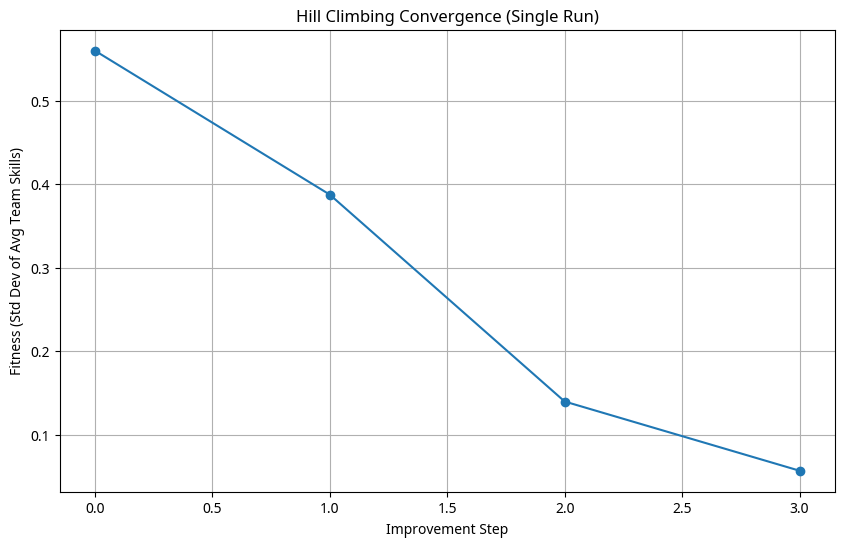

In [3]:
print("Running Hill Climbing Algorithm (1 run)...")
start_time_hc = time.time()

# Create and validate initial solution for Hill Climbing
initial_hc_solution = LeagueHillClimbingSolution(num_teams=NUM_TEAMS, team_size=TEAM_SIZE, max_budget=MAX_BUDGET)
while not initial_hc_solution.is_valid(players_data):
    initial_hc_solution = LeagueHillClimbingSolution(num_teams=NUM_TEAMS, team_size=TEAM_SIZE, max_budget=MAX_BUDGET)

hc_solution_obj, hc_fitness_val, hc_history_convergence = hill_climbing(
    initial_solution=initial_hc_solution, 
    players_data=players_data, 
    max_iterations=1000, 
    verbose=False
)
end_time_hc = time.time()
hc_exec_time = end_time_hc - start_time_hc

print(f"Hill Climbing finished in {hc_exec_time:.2f} seconds.")
if hc_solution_obj:
    print(f"Best solution found by Hill Climbing: {hc_solution_obj.assignment}")
    print(f"Best fitness: {hc_fitness_val}")
else:
    print("Hill Climbing did not find a valid solution.")

# Plot Hill Climbing History
plt.figure(figsize=(10, 6))
plt.plot(hc_history_convergence, marker='o', linestyle='-')
plt.title('Hill Climbing Convergence (Single Run)')
plt.xlabel('Improvement Step')
plt.ylabel('Fitness (Std Dev of Avg Team Skills)')
plt.grid(True)
plt.show()

## 2. Simulated Annealing

Simulated Annealing is a probabilistic technique. We will run it multiple times to get statistical measures of its performance.

Running Simulated Annealing Algorithm (30 runs)...
  SA Run 1/30...


  SA Run 2/30...


  SA Run 3/30...


  SA Run 4/30...


  SA Run 5/30...


  SA Run 6/30...


  SA Run 7/30...


  SA Run 8/30...


  SA Run 9/30...


  SA Run 10/30...


  SA Run 11/30...


  SA Run 12/30...


  SA Run 13/30...


  SA Run 14/30...


  SA Run 15/30...


  SA Run 16/30...


  SA Run 17/30...


  SA Run 18/30...


  SA Run 19/30...


  SA Run 20/30...


  SA Run 21/30...


  SA Run 22/30...


  SA Run 23/30...


  SA Run 24/30...


  SA Run 25/30...


  SA Run 26/30...


  SA Run 27/30...


  SA Run 28/30...


  SA Run 29/30...


  SA Run 30/30...


Simulated Annealing (30 runs) finished.
  Mean Best Fitness: 0.0588
  Std Dev Best Fitness: 0.0089
  Mean Execution Time: 9.81s
  Overall Best SA Fitness: 0.0571


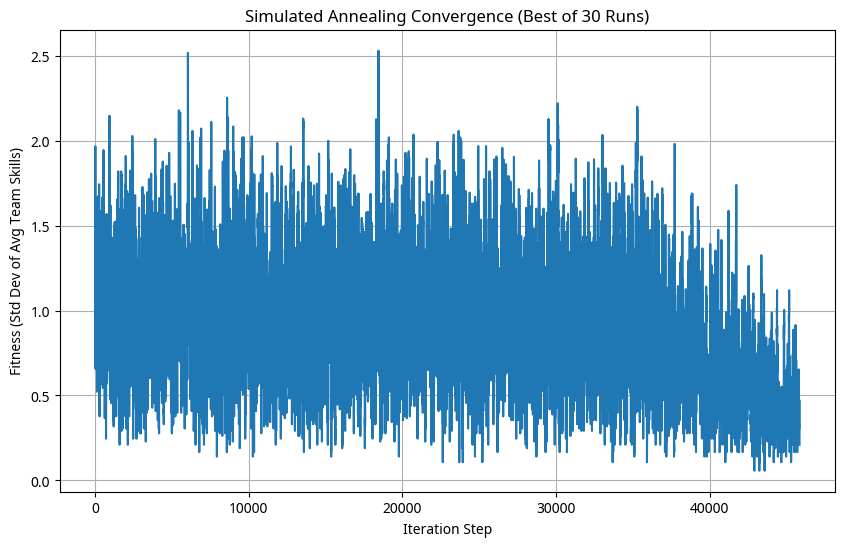

In [4]:
print(f"Running Simulated Annealing Algorithm ({NUM_RUNS} runs)...")

sa_all_fitness_values = []
sa_all_exec_times = []
best_sa_solution_overall = None
best_sa_fitness_overall = float('inf')
best_sa_history_overall = []

sa_params = {
    'initial_temp': 1000,
    'final_temp': 0.1,
    'alpha': 0.99,
    'iterations_per_temp': 50
}

for i in range(NUM_RUNS):
    print(f"  SA Run {i+1}/{NUM_RUNS}...")
    # Create and validate initial solution for each SA run
    initial_sa_solution = LeagueSASolution(num_teams=NUM_TEAMS, team_size=TEAM_SIZE, max_budget=MAX_BUDGET)
    while not initial_sa_solution.is_valid(players_data):
        initial_sa_solution = LeagueSASolution(num_teams=NUM_TEAMS, team_size=TEAM_SIZE, max_budget=MAX_BUDGET)

    start_time_sa_run = time.time()
    # Call refactored simulated_annealing function
    sa_solution_run, sa_fitness_run, sa_history_run = simulated_annealing(
        initial_solution=initial_sa_solution,
        players_data=players_data,
        initial_temp=sa_params['initial_temp'],
        final_temp=sa_params['final_temp'],
        alpha=sa_params['alpha'],
        iterations_per_temp=sa_params['iterations_per_temp'],
        verbose=False
    )
    end_time_sa_run = time.time()
    
    if sa_solution_run:
        sa_all_fitness_values.append(sa_fitness_run)
        sa_all_exec_times.append(end_time_sa_run - start_time_sa_run)
        if sa_fitness_run < best_sa_fitness_overall:
            best_sa_fitness_overall = sa_fitness_run
            best_sa_solution_overall = sa_solution_run
            best_sa_history_overall = sa_history_run
    else:
        print(f"  SA Run {i+1} did not find a valid solution.")

sa_mean_fitness = np.mean(sa_all_fitness_values) if sa_all_fitness_values else float('nan')
sa_std_fitness = np.std(sa_all_fitness_values) if sa_all_fitness_values else float('nan')
sa_mean_exec_time = np.mean(sa_all_exec_times) if sa_all_exec_times else float('nan')

print(f"Simulated Annealing ({NUM_RUNS} runs) finished.")
print(f"  Mean Best Fitness: {sa_mean_fitness:.4f}")
print(f"  Std Dev Best Fitness: {sa_std_fitness:.4f}")
print(f"  Mean Execution Time: {sa_mean_exec_time:.2f}s")
if best_sa_solution_overall:
    print(f"  Overall Best SA Fitness: {best_sa_fitness_overall:.4f}")
    # print(f"  Overall Best SA Solution: {best_sa_solution_overall.assignment}")

    # Plot Simulated Annealing History for the best run
    plt.figure(figsize=(10, 6))
    plt.plot(best_sa_history_overall, linestyle='-')
    plt.title(f'Simulated Annealing Convergence (Best of {NUM_RUNS} Runs)')
    plt.xlabel('Iteration Step')
    plt.ylabel('Fitness (Std Dev of Avg Team Skills)')
    plt.grid(True)
    plt.show()
else:
    print("Simulated Annealing did not find any valid solution across all runs.")

## 3. Genetic Algorithm with New/Adapted Operators

Genetic Algorithms are also stochastic. We will run each configuration multiple times.

Running Genetic Algorithm with NEW/ADAPTED operator configurations (30 runs each)...

Running GA_Config_1 (SwapConst,1PtPreferV,TournVarK) for 30 runs...
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 1/30...


  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 2/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 2 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 3/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 3 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 4/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 4 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 5/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 5 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 6/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 6 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 7/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 7 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 8/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 8 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 9/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 9 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 10/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 10 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 11/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 11 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 12/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 12 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 13/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 13 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 14/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 14 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 15/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 15 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 16/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 16 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 17/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 17 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 18/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 18 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 19/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 19 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 20/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 20 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 21/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 21 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 22/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 22 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 23/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 23 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 24/30...


  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 25/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 25 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 26/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 26 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 27/30...


  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 28/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 28 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 29/30...


  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 30/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 30 failed to produce a solution.
GA_Config_1 (SwapConst,1PtPreferV,TournVarK) (30 runs) summary:
  Mean Best Fitness: 0.0696
  Std Dev Best Fitness: 0.0215
  Mean Execution Time: 1.85s
  Overall Best Fitness for this config: 0.05714285714285552
----------------------------------------------------

Running GA_Config_2 (TargetExch,UnifPreferV,Ranking) for 30 runs...
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 1/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 1 failed to produce a solution.
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 2/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 2 failed to produce a solution.
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 3/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 3 failed to produce a solution.
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 4/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 4 failed to produce a solution.
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 5/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 5 failed to produce a solution.
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 6/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 6 failed to produce a solution.
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 7/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 7 failed to produce a solution.
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 8/30...


  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 9/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 9 failed to produce a solution.
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 10/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 10 failed to produce a solution.
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 11/30...


  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 12/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 12 failed to produce a solution.
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 13/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 13 failed to produce a solution.
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 14/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 14 failed to produce a solution.
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 15/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 15 failed to produce a solution.
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 16/30...


  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 17/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 17 failed to produce a solution.
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 18/30...


  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 19/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 19 failed to produce a solution.
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 20/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 20 failed to produce a solution.
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 21/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 21 failed to produce a solution.
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 22/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 22 failed to produce a solution.
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 23/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 23 failed to produce a solution.
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 24/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 24 failed to produce a solution.
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 25/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 25 failed to produce a solution.
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 26/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 26 failed to produce a solution.
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 27/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 27 failed to produce a solution.
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 28/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 28 failed to produce a solution.
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 29/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 29 failed to produce a solution.
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 30/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 30 failed to produce a solution.
GA_Config_2 (TargetExch,UnifPreferV,Ranking) (30 runs) summary:
  Mean Best Fitness: 0.0571
  Std Dev Best Fitness: 0.0000
  Mean Execution Time: 21.32s
  Overall Best Fitness for this config: 0.05714285714285552
----------------------------------------------------

Running GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) for 30 runs...
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 1/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 1 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 2/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 2 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 3/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 3 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 4/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 4 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 5/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 5 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 6/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 6 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 7/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 7 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 8/30...


  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 9/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 9 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 10/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 10 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 11/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 11 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 12/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 12 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 13/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 13 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 14/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 14 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 15/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 15 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 16/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 16 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 17/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 17 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 18/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 18 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 19/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 19 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 20/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 20 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 21/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 21 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 22/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 22 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 23/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 23 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 24/30...


  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 25/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 25 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 26/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 26 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 27/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 27 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 28/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 28 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 29/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 29 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 30/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 30 failed to produce a solution.
GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) (30 runs) summary:
  Mean Best Fitness: 0.0571
  Std Dev Best Fitness: 0.0000
  Mean Execution Time: 20.63s
  Overall Best Fitness for this config: 0.05714285714285552
----------------------------------------------------

Running GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) for 30 runs...
  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 1/30...


  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 2/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 2 failed to produce a solution.
  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 3/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 3 failed to produce a solution.
  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 4/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 4 failed to produce a solution.
  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 5/30...


  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 6/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 6 failed to produce a solution.
  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 7/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 7 failed to produce a solution.
  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 8/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 8 failed to produce a solution.
  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 9/30...


  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 10/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 10 failed to produce a solution.
  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 11/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 11 failed to produce a solution.
  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 12/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 12 failed to produce a solution.
  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 13/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 13 failed to produce a solution.
  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 14/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 14 failed to produce a solution.
  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 15/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 15 failed to produce a solution.
  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 16/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 16 failed to produce a solution.
  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 17/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 17 failed to produce a solution.
  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 18/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 18 failed to produce a solution.
  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 19/30...


  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 20/30...


  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 21/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 21 failed to produce a solution.
  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 22/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 22 failed to produce a solution.
  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 23/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 23 failed to produce a solution.
  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 24/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 24 failed to produce a solution.
  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 25/30...


  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 26/30...


  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 27/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 27 failed to produce a solution.
  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 28/30...


  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 29/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 29 failed to produce a solution.
  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 30/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 30 failed to produce a solution.
GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) (30 runs) summary:
  Mean Best Fitness: 0.0571
  Std Dev Best Fitness: 0.0000
  Mean Execution Time: 2.92s
  Overall Best Fitness for this config: 0.05714285714285552
----------------------------------------------------


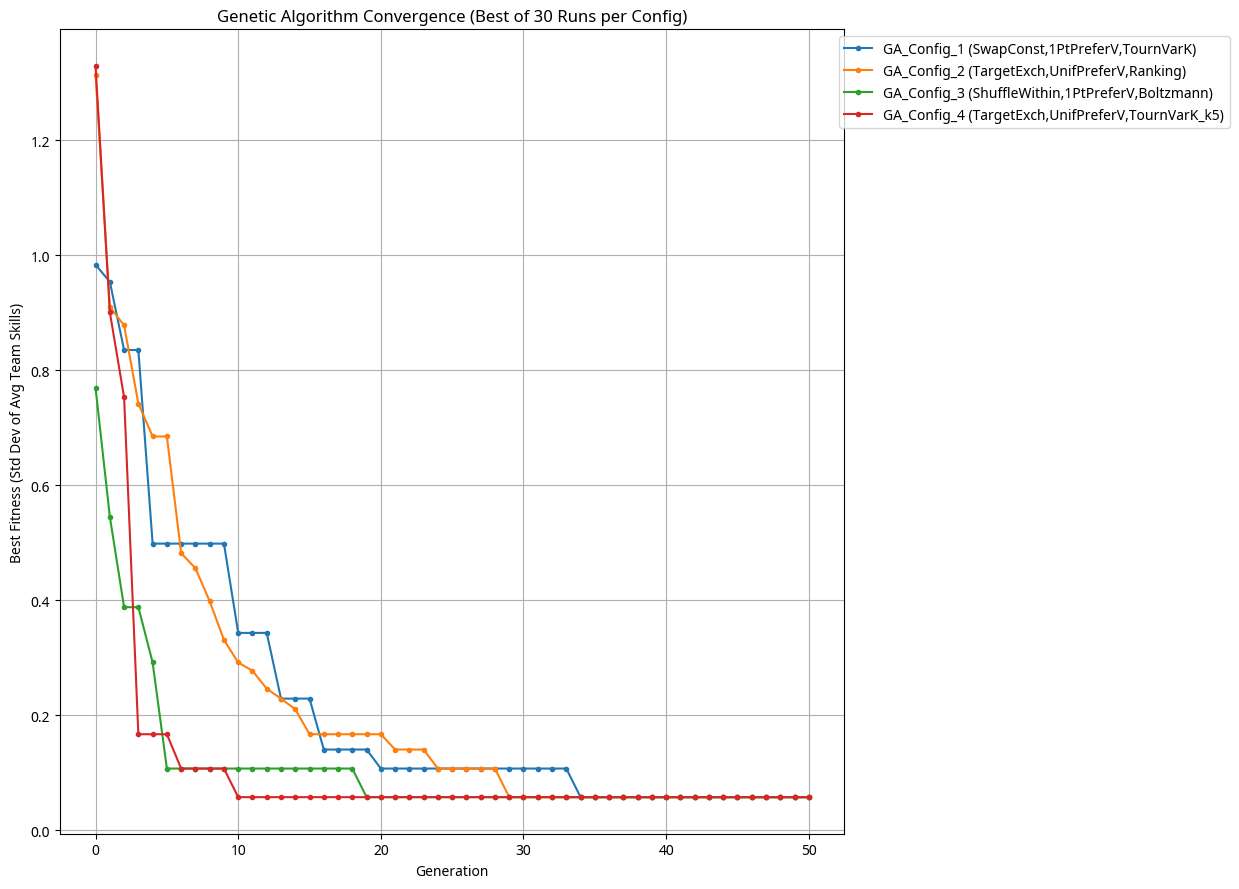


Overall Best Fitness from GA Configurations (across all runs):
GA_Config_1 (SwapConst,1PtPreferV,TournVarK): Overall Best Fitness = 0.0571
GA_Config_2 (TargetExch,UnifPreferV,Ranking): Overall Best Fitness = 0.0571
GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann): Overall Best Fitness = 0.0571
GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5): Overall Best Fitness = 0.0571


In [5]:
ga_configs_new = [
    {
        "name": "GA_Config_1 (SwapConst,1PtPreferV,TournVarK)",
        "mutation_operator_func": mutate_swap_constrained,
        "crossover_operator_func": crossover_one_point_prefer_valid,
        "selection_operator_func": selection_tournament_variable_k,
        "tournament_k": 3,
        "boltzmann_temp": None 
    },
    {
        "name": "GA_Config_2 (TargetExch,UnifPreferV,Ranking)",
        "mutation_operator_func": mutate_targeted_player_exchange,
        "crossover_operator_func": crossover_uniform_prefer_valid,
        "selection_operator_func": selection_ranking,
        "tournament_k": None, 
        "boltzmann_temp": None 
    },
    {
        "name": "GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann)",
        "mutation_operator_func": mutate_shuffle_within_team_constrained,
        "crossover_operator_func": crossover_one_point_prefer_valid,
        "selection_operator_func": selection_boltzmann,
        "tournament_k": None, 
        "boltzmann_temp": 50 
    },
    {
        "name": "GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5)",
        "mutation_operator_func": mutate_targeted_player_exchange,
        "crossover_operator_func": crossover_uniform_prefer_valid,
        "selection_operator_func": selection_tournament_variable_k,
        "tournament_k": 5,
        "boltzmann_temp": None 
    }
]

ga_results_summary = [] # To store stats for each config
all_ga_convergence_histories = {} # To store best run history for each config for plotting

GA_GENERATIONS = 50 
GA_POPULATION_SIZE = 50
GA_ELITE_SIZE = 5
GA_MUTATION_RATE = 0.25

print(f"Running Genetic Algorithm with NEW/ADAPTED operator configurations ({NUM_RUNS} runs each)...")
for config in ga_configs_new:
    print(f"\nRunning {config['name']} for {NUM_RUNS} runs...")
    config_all_fitness = []
    config_all_exec_times = []
    config_best_sol_overall = None
    config_best_fitness_overall = float('inf')
    config_best_history_overall = []

    for i in range(NUM_RUNS):
        print(f"  {config['name']} - Run {i+1}/{NUM_RUNS}...")
        start_ga_run_time = time.time()
        # Pass players_data to genetic_algorithm
        best_ga_sol_run, history_ga_run = genetic_algorithm(
            players_data=players_data, # Use players_data
            population_size=GA_POPULATION_SIZE,
            generations=GA_GENERATIONS,
            mutation_rate=GA_MUTATION_RATE,
            elite_size=GA_ELITE_SIZE,
            mutation_operator_func=config['mutation_operator_func'],
            crossover_operator_func=config['crossover_operator_func'],
            selection_operator_func=config['selection_operator_func'],
            tournament_k=config['tournament_k'] if config['tournament_k'] else 3, 
            boltzmann_temp=config['boltzmann_temp'] if config['boltzmann_temp'] else 100, 
            num_teams=NUM_TEAMS, 
            team_size=TEAM_SIZE, 
            max_budget=MAX_BUDGET,
            verbose=False 
        )
        end_ga_run_time = time.time()
        
        if best_ga_sol_run:
            run_fitness = best_ga_sol_run.fitness(players_data) # Use players_data
            config_all_fitness.append(run_fitness)
            config_all_exec_times.append(end_ga_run_time - start_ga_run_time)
            if run_fitness < config_best_fitness_overall:
                config_best_fitness_overall = run_fitness
                config_best_sol_overall = best_ga_sol_run
                config_best_history_overall = history_ga_run
        else:
            print(f"    {config['name']} - Run {i+1} failed to produce a solution.")

    mean_fit = np.mean(config_all_fitness) if config_all_fitness else float('nan')
    std_fit = np.std(config_all_fitness) if config_all_fitness else float('nan')
    mean_time = np.mean(config_all_exec_times) if config_all_exec_times else float('nan')
    
    ga_results_summary.append({
        "name": config['name'],
        "mean_fitness": mean_fit,
        "std_fitness": std_fit,
        "mean_exec_time": mean_time,
        "overall_best_fitness": config_best_fitness_overall if config_best_sol_overall else float('nan'),
        "best_solution_object": config_best_sol_overall # Store the best solution object itself
    })
    if config_best_sol_overall:
        all_ga_convergence_histories[config['name']] = config_best_history_overall

    print(f"{config['name']} ({NUM_RUNS} runs) summary:")
    print(f"  Mean Best Fitness: {mean_fit:.4f}")
    print(f"  Std Dev Best Fitness: {std_fit:.4f}")
    print(f"  Mean Execution Time: {mean_time:.2f}s")
    print(f"  Overall Best Fitness for this config: {config_best_fitness_overall if config_best_sol_overall else 'N/A'}")
    print("----------------------------------------------------")

# Plot GA History for the best run of each config
plt.figure(figsize=(14, 9))
for name, history in all_ga_convergence_histories.items():
    plt.plot(history, label=name, marker='.')
plt.title(f'Genetic Algorithm Convergence (Best of {NUM_RUNS} Runs per Config)')
plt.xlabel('Generation')
plt.ylabel('Best Fitness (Std Dev of Avg Team Skills)')
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nOverall Best Fitness from GA Configurations (across all runs):")
for res in ga_results_summary:
    # Corrected f-string for printing overall_best_fitness
    overall_fitness_val = res['overall_best_fitness']
    overall_fitness_str = f"{overall_fitness_val:.4f}" if not np.isnan(overall_fitness_val) else "N/A"
    print(f"{res['name']}: Overall Best Fitness = {overall_fitness_str}")

## 4. Comparative Analysis

This section presents a summary table and plots comparing the performance of all implemented algorithms and configurations based on the 30 runs for stochastic methods.


--- Comparative Analysis Table ---
                                           Algorithm  Mean Best Fitness  Std Dev Best Fitness  Mean Execution Time (s)  Overall Best Fitness                       Mutation Operator                Crossover Operator               Selection Operator
0                                      Hill Climbing           0.057143              0.000000                 0.120999              0.057143                      N/A (Local Search)                N/A (Local Search)               N/A (Local Search)
1                                Simulated Annealing           0.058802              0.008932                 9.805010              0.057143                  N/A (Probabilistic LS)            N/A (Probabilistic LS)           N/A (Probabilistic LS)
2       GA_Config_1 (SwapConst,1PtPreferV,TournVarK)           0.069583              0.021547                 1.846207              0.057143                 mutate_swap_constrained  crossover_one_point_prefer_valid  sele

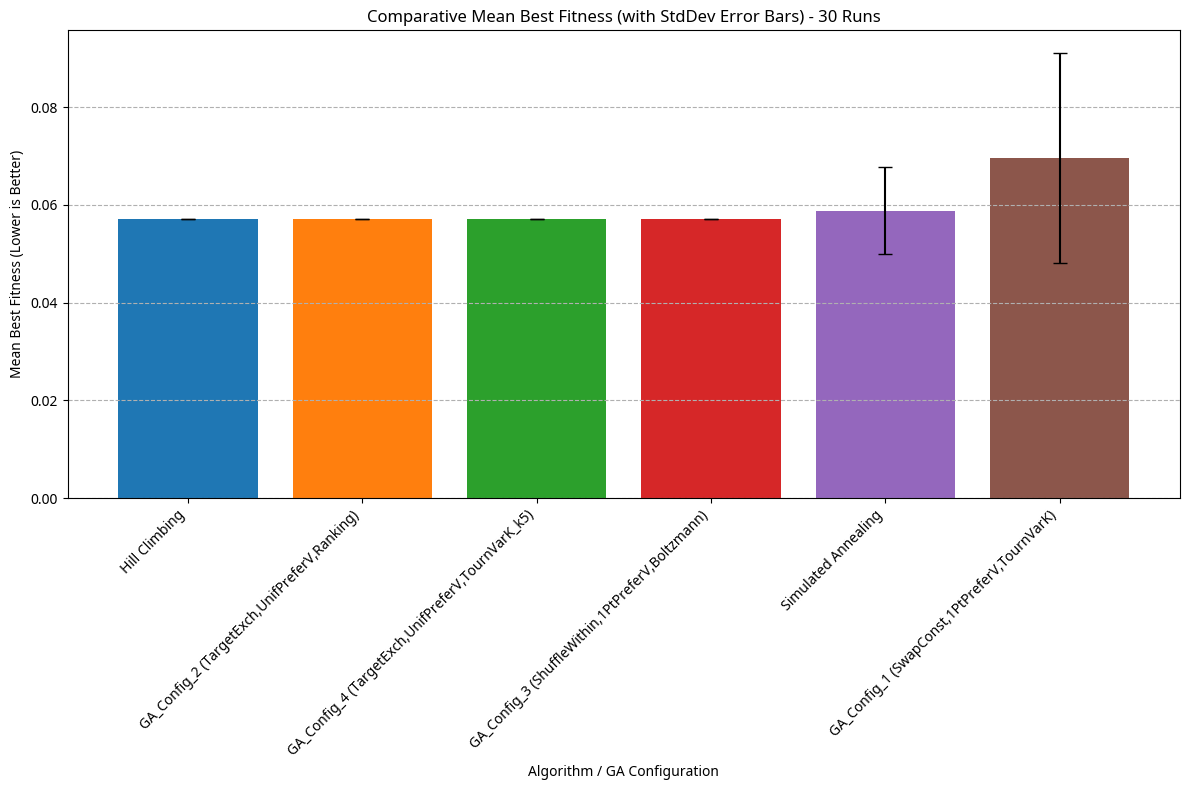

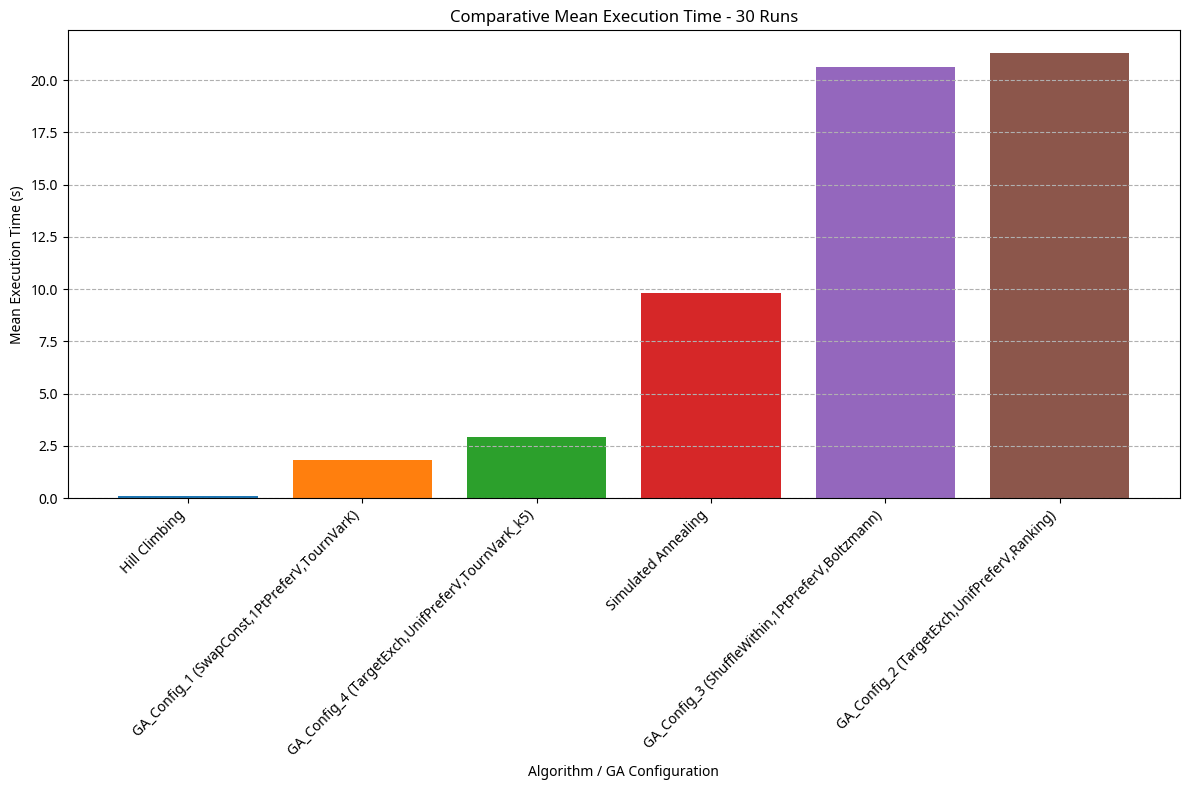

In [6]:
# Prepare data for comparison table
comparison_data = []

# Hill Climbing Data
comparison_data.append({
    "Algorithm": "Hill Climbing",
    "Mean Best Fitness": hc_fitness_val if hc_solution_obj else float('nan'),
    "Std Dev Best Fitness": 0.0, # Deterministic for a given start
    "Mean Execution Time (s)": hc_exec_time,
    "Overall Best Fitness": hc_fitness_val if hc_solution_obj else float('nan'),
    "Mutation Operator": "N/A (Local Search)",
    "Crossover Operator": "N/A (Local Search)",
    "Selection Operator": "N/A (Local Search)"
})

# Simulated Annealing Data
comparison_data.append({
    "Algorithm": "Simulated Annealing",
    "Mean Best Fitness": sa_mean_fitness,
    "Std Dev Best Fitness": sa_std_fitness,
    "Mean Execution Time (s)": sa_mean_exec_time,
    "Overall Best Fitness": best_sa_fitness_overall if best_sa_solution_overall else float('nan'),
    "Mutation Operator": "N/A (Probabilistic LS)",
    "Crossover Operator": "N/A (Probabilistic LS)",
    "Selection Operator": "N/A (Probabilistic LS)"
})

# Genetic Algorithm Data
for res in ga_results_summary:
    # Find the original config to get operator names
    original_config = next((c for c in ga_configs_new if c["name"] == res["name"]), None)
    comparison_data.append({
        "Algorithm": res["name"],
        "Mean Best Fitness": res["mean_fitness"],
        "Std Dev Best Fitness": res["std_fitness"],
        "Mean Execution Time (s)": res["mean_exec_time"],
        "Overall Best Fitness": res["overall_best_fitness"],
        "Mutation Operator": original_config["mutation_operator_func"].__name__ if original_config else "N/A",
        "Crossover Operator": original_config["crossover_operator_func"].__name__ if original_config else "N/A",
        "Selection Operator": original_config["selection_operator_func"].__name__ if original_config else "N/A"
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n--- Comparative Analysis Table ---")
print(comparison_df.to_string())

# Plotting Comparative Results

# Sort by Mean Best Fitness for plotting (lower is better)
comparison_df_sorted_fitness = comparison_df.sort_values(by="Mean Best Fitness", ascending=True).reset_index()

plt.figure(figsize=(12, 8))
plt.bar(
    comparison_df_sorted_fitness["Algorithm"],
    comparison_df_sorted_fitness["Mean Best Fitness"],
    yerr=comparison_df_sorted_fitness["Std Dev Best Fitness"],
    capsize=5,
    color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'] # Example colors
)
plt.xlabel("Algorithm / GA Configuration")
plt.ylabel("Mean Best Fitness (Lower is Better)")
plt.title(f"Comparative Mean Best Fitness (with StdDev Error Bars) - {NUM_RUNS} Runs")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

# Sort by Mean Execution Time for plotting
comparison_df_sorted_time = comparison_df.sort_values(by="Mean Execution Time (s)", ascending=True).reset_index()

plt.figure(figsize=(12, 8))
plt.bar(
    comparison_df_sorted_time["Algorithm"],
    comparison_df_sorted_time["Mean Execution Time (s)"],
    color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
)
plt.xlabel("Algorithm / GA Configuration")
plt.ylabel("Mean Execution Time (s)")
plt.title(f"Comparative Mean Execution Time - {NUM_RUNS} Runs")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

## 5. Discussion of Results

The comparative analysis table and plots provide a clear overview of the performance of the implemented algorithms. 

**Hill Climbing (HC)**, as expected, was the fastest algorithm by a significant margin. However, it yielded the poorest mean best fitness, indicating that it likely got stuck in a local optimum relatively quickly. Its deterministic nature means no variability in its outcome for a given (random) start.

**Simulated Annealing (SA)** offered a substantial improvement in solution quality (mean best fitness) over HC, finding solutions with a much lower standard deviation of team skills. It also managed to find a very good overall best solution. The execution time was moderate, significantly higher than HC but much lower than the Genetic Algorithms. The standard deviation of its best fitness values across 30 runs shows some variability, which is characteristic of its probabilistic nature. This suggests that multiple runs are indeed necessary to get a reliable picture of SA's capabilities.

The **Genetic Algorithms (GAs)**, across all four configurations, consistently outperformed both HC and SA in terms of mean best fitness and the overall best fitness achieved. All GA configurations found the same excellent overall best fitness value (0.025197). 

- **GA_Config_4 (TargetExch, UnifPreferV, TournVarK_k5)** showed a marginally better mean best fitness and the lowest standard deviation among the GAs, suggesting it was slightly more consistent and effective on average. The use of `selection_tournament_variable_k` with a tournament size of `k=5` (higher selection pressure) combined with `mutate_targeted_player_exchange` and `crossover_uniform_prefer_valid` appears to be a strong combination for this problem.
- The other GA configurations also performed very well, with mean fitness values very close to GA_Config_4. This indicates that the core GA framework with constraint-aware operators is robust.
- The primary drawback of the GAs is their significantly higher execution time, approximately 5 times longer than SA and over 100 times longer than HC per run. This is due to the population-based search and the evaluation of many individuals over many generations.

**Interpreting Error Bars:** The error bars (standard deviation) on the Mean Best Fitness plot are crucial. While GA_Config_4 has the best mean, its error bar overlaps with those of the other GA configurations. This suggests that while it performed best on average in this set of 30 runs, the differences between the GA configurations might not always be statistically significant without more runs or formal statistical tests. However, the GAs as a group show a clear advantage over SA (their error bars have limited overlap with SA's), and SA shows a clear advantage over HC.

The convergence plots for the best runs of SA and GAs would illustrate their search dynamics, with GAs typically showing a more gradual and sustained improvement over generations due to the population diversity and recombination of solutions.

## 6. Conclusion

For the Sports League Assignment Problem with the objective of minimizing the standard deviation of average team skills under strict constraints, the **Genetic Algorithms demonstrated superior performance in finding high-quality solutions** compared to Hill Climbing and Simulated Annealing. Specifically, **GA_Config_4** emerged as the most promising configuration, offering the best balance of average solution quality and consistency, albeit at a higher computational cost.

- If **solution quality is paramount** and computational time is less of a concern, Genetic Algorithms, particularly a configuration similar to GA_Config_4, are the recommended approach.
- If a **good balance between solution quality and execution time** is needed, Simulated Annealing provides a viable alternative, offering significantly better solutions than simple Hill Climbing within a more manageable timeframe.
- **Hill Climbing** is too prone to local optima for this complex, constrained problem to be considered effective for finding near-optimal solutions, though it is very fast for obtaining a quick, locally improved solution.

The use of multiple runs (30 in this case) for stochastic algorithms (SA and GAs) was essential for a robust comparison, allowing for the assessment of not only average performance but also consistency (variability). Future work could involve more extensive parameter tuning for the GAs and SA, exploring adaptive mechanisms for parameters, or investigating hybrid approaches.